# Water Quality, Perception and Knowledge in China: *Data Analysis (condensed)*

This document is the data analysis of water quality, water quality perception, and water quality knowledge in China. The analysis is driven primarily by two datasets - water quality (2017, per prefecture) and a national general social survey (China General Social Survey, 2010) with an environmental module.

## Research Questions and Hypotheses

| Question Number | Research Question                                                                                                       | H0 (Null Hypothesis)                                                       | H1 (Hypothesis)                                                                                                            |
|:---------------|:-----------------------------------------------------------------------------------------------------------------------|:--------------------------------------------------------------------------|:--------------------------------------------------------------------------------------------------------------------------|
| R1              | Is there a relationship between water quality and perception of water quality? (I.e. do perceptions and reality match)? | Local water quality is unrelated to water quality perception.   | Local (provincial) water quality relates to water quality perception. |
| R2              | Does knowledge of water quality affect perception?                                                                      | Increased knowledge is independent of perception.                          | An increase knowledge of water quality issues relates to an increased perception of severity.                              |
| R3              | Does the level of obtained education relate to water quality knowledge?                                                 | Increased education is independent of knowledge of water quality.          | Increased education relates to more knowledge about water quality.                                                         |
| R4              | Does the level of obtained education relate perception?                                                                 | Increased education is independent of an increased perception of severity. | Increased education relates to an increased perception of severity                                                         |
| R5              | Are there differences between water quality perception, and water quality knowledge, in rural vs. urban households?     | There is no significant difference between urban and rural households.     | There is a significant difference in perception of severity of water quality issues between urban and rural households.    |
| R6              | Is there a relationship between water quality and knowledge of water quality?                                           | There is no relation between water quality and water quality knowledge.    | There is a relation between water quality and water quality knowledge.                                                     |

## Core Analyzed Data

| Code  | English                                                                                                                                           | Chinese                                                          | Value Range (used)                           |
|:-------|:---------------------------------------------------------------------------------------------------------------------------------------------------|:------------------------------------------------------------------|:----------------------------------------------|
| s41   | Province                                                                                                                                          | 省                                                                | Range, *see data analysis*                   |
| a2    | Gender                                                                                                                                            | 性别                                                               | 1 = male, 2 = female                         |
| a3a   | Birth year                                                                                                                                        | 您的出生日期是什么                                                        | Birth year                                   |
| a7a   | Highest level of obtained education                                                                                                               | 您目前的最高教育程度是                                                      | 1 = none, 13 = master's and above            |
| a91   | Rural / agricultural household                                                                                                                    | 请问目前您或者您配偶是否为农业户口(或者户口所在地为农村),且在农村(包括家乡和其它地方)有承包的旱地、水田、山林、水面等土地? | 1 = yes, 2 = no                              |
| l14d  | "How do you think the pollution of rivers, rivers and lakes in China is harmful to the environment?" (*Used to measure perception*)               | 您认为中国的江、河、湖泊的污染对环境的危害程度是?                                        | 1 = very important, 5 = not important at all |
| l2409 | "In the domestic water pollution report, the water quality of Category V (5) is better than that of Category I (1)" (*Used to measure knowledge, response==2 is correct*) | 国内水体污染报告中,V(5)类水质要比I(1)类水质好                                      | 1 = correct, **2 = incorrect**               |


More information about the thesis, motivation, and methodology is located in the main "thesis_analysis.ipynb" document.

## Load Data

Load Python libraries

In [204]:
import pandas as pd
from pandas import DataFrame
import numpy as np # for some regression visualizations
import matplotlib as mpl
import matplotlib.pyplot as plt # for some visualizations
import seaborn as sns # for plots
import statsmodels.api as sm # for statistical analysis
import statsmodels.formula.api as smf # for statistical analysis
from sklearn import preprocessing # for normalizing data
import pingouin as pi # for statistical analysis

In [205]:
# Returns ALL columns when displaying DataFrame, useful for finding column names
pd.set_option('display.max_columns', None)

In [206]:
# Set the standard theme for plots
sns.set_theme(
    # palette='PuOr_r',
    style="ticks",
    context='paper', #scale of fonts, etc.
    font='DejaVu Sans')

sns.set_palette('Purples_r', 3)
#mpl.rcParams['font.family'] = 'DejaVu Sans'

Load CGSS (social survey) data from a Stata file

In [207]:
cgss = pd.read_stata('../data/cgss2010_12.dta', preserve_dtypes = True, convert_categoricals=False)
cgss.describe()

,id,s41,s42,s43,s44,s45,s5,a1202,a1402,a1502,a1602,a1203,a1403,a1503,a1603,a1204,a1404,a1504,a1604,a1205,a1405,a1505,a1605,a1206,a1406,a1506,a1606,a1207,a1407,a1507,a1607,a1208,a1408,a1508,a1608,a1209,a1409,a1509,a1609,a1210,a1410,a1510,a1610,a1211,a1411,a1511,a1611,a1212,a1412,a1512,a1612,a1213,a1413,a1513,a1613,a1214,a1414,a1514,a1614,a1215,a1415,a1515,a1615,a13201,a13202,a13203,a13204,a13205,a13206,a13207,a13208,a13209,a13210,a13211,a13212,a13213,a13214,a13301,a13302,a13303,a13304,a13305,a13306,a13307,a13308,a13309,a13310,a13311,a13312,a13313,a13401,a13402,a13403,a13404,a13405,a13406,a13407,a13408,a13409,a13410,a13411,a13412,a13501,a13502,a13503,a13504,a13505,a13506,a13507,a13508,a13509,a13510,a13511,a13601,a13602,a13603,a13604,a13605,a13606,a13607,a13608,a13609,a13610,a13701,a13702,a13703,a13704,a13705,a13706,a13707,a13708,a13709,a13801,a13802,a13803,a13804,a13805,a13806,a13807,a13808,a13901,a13902,a13903,a13904,a13905,a13906,a13907,a131001,a131002,a131003,a131004,a131005,a131006,a131101,a131102,a131103,a131104,a131105,a131201,a131202,a131203,a131204,a131301,a131302,a131303,a131401,a131402,a131501,a2,a3a,a3b,a3c,a4,a5,a6,a7a,a7b,a7c,a8a,a8b,a9,a9a,a10,a10a,a11,a121,a122,a123,a124,a125,a126,a127,a128,a13,a14,a15,a16,a17,a18,a19,a20,a21,a23,a24,a25,a281,a282,a283,a284,a285,a286,a29,a3001,a3002,a3003,a3004,a3005,a3006,a3007,a3008,a3009,a3010,a3011,a3012,a311,a312,a313,a32,a33,a34,a35,a36,a371,a372,a373,a38,a39,a40,a41,a421,a422,a423,a424,a425,a43a,a43b,a43c,a43d,a44,a45,a46,a47,a48,a49,a50,a51,a52,a53,a53a,a54,a55,a561,a562,a563,a564,a565,a566,a567,a57,a58,a59a,a59aa,a59b,a59ba,a59c,a59e,a59f,a59fa,a59g,a59h,a59j,a59k,a59m,a60a,a60aa,a60b,a60ba,a60c,a60e,a60f,a60fa,a60g,a60h,a60j,a60k,a60m,a611,a612,a62,a6301,a6302,a6303,a6304,a6305,a6306,a6307,a6308,a6309,a6310,a6311,a64,a65,a66,a671,a672,a673,a674,a675,a676,a677,a678,a679,a681,a682,a69,a70,a71a,a71b,a72,a73,a74,a75,a76,a76a,a77,a78,a79,a80,a81,a82,a82a,a83,a83a,a85,a87,a88,a89a,a89b,a89c,a89d,a89da,a89f,a89g,a89h,a90a,a90b,a90c,a90d,a90da,a90f,a90g,a90h,a91,a92,b111,b121,b131,b141,b151,b112,b122,b132,b142,b152,b113,b123,b133,b143,b153,b114,b124,b134,b144,b154,b21,b22,b23,b24,b3,b4,b5,b6,b7,b8,b9,b1011,b1012,b1021,b1022,b11,b12,b13,b14,b15,b16,b17,b18,b19,b20,c1,c201,c202,c203,c204,c205,c206,c207,c208,c209,c210,c211,c212,c213,c214,c215,c216,c301,c302,c303,c304,c305,c306,c307,c308,c309,c310,c4,c5,c6,c7a,c7b,c8a,c8b,c8c1,c8c2,c8c3,c8c4,c8c5,c8c6,c8c7,c8c8,c911,c921,c912,c922,c913,c923,c914,c924,c915,c925,c916,c926,c101,c102,c103,c104,c105,c106,d1a,d1b,d1c,d1d,d1e,d1f,d2a,d2b,d2c,d2d,d2e,d2f,d2g,d2h,d2i,d301,d302,d303,d304,d305,d306,d307,d308,d309,d310,d311,d312,d4a,d4b,d4c,d4d,d5a,d5b,d601,d602,d603,d604,d605,d606,d607,d608,d609,d610,d71,d72,d73,d74,d8,d91,d92,d93,d94,d95,d96,d1001,d1002,d1003,d1004,d1005,d1006,d1007,d1008,d1009,d1010,d1011,d111,d112,d12a,d12aa,d12b,d12c,d12d1,d12d2,d12d3,d12d4,d12d5,d12d6,d12d7,d12d8,d13a,d13b01,d13b02,d13b03,d13b04,d13b05,d13b06,d13b07,d13b08,d13b09,d13b10,d13b11,d13b12,d13b13,d14,d15,d16,d17,d181,d182,d183,d184,d185,d186,d187,d19a,d19b,d19c,d19d,d19e1,d19e2,d19e3,d19e4,d19e5,d19e6,d19e7,d201,d202,d203,d204,d205,d206,d207,d211,d212,d213,d214,d215,d216,d217,d218,d221,d222,d223,d224,d225,d226,d227,l1a,l1b,l2a,l2b,l3a,l3b,l5a,l5b,l6a,l6b,l7a,l7b,l7c,l8a,l8b,l9a,l9b,l9c,l10a,l10b,l10c,l11a,l11b,l11c,l12a,l12b,l12c,l131,l132,l133,l134,l135,l136,l137,l14a,l14b,l14c,l14d,l14e,l14f,l14g,l15a,l15b,l16a,l16b,l16c,l17a,l17b,l18,l19a1,l19a2,l19a3,l19b,l20a,l20b,l20c,l20d,l20e,l20f,l21,l22a,l22b,l22c,l23a,l23b,l2401,l2402,l2403,l2404,l2405,l2406,l2407,l2408,l2409,l2410,l2501,l2502,l2503,l2504,l2505,l2506,l2507,l2508,l2509,l2510,l2511,l2512,l2513,l2514,l2515,msfq2,msfq3,msfq4,msfq6,msfq7,msfq8,msfq9,msfq10,msfq12,ma13,ma14,ma15,ma161,ma162,ma163,ma164,ma165,ma166,mb1,mb2,mb3,mb4,mb5,mc1,mc2a,mc2b,mc3,mc401,mc402,mc403,mc404,mc405,mc406,mc407,mc408,mc409,mc410,md1,me1a,me1b,me1c,mf1a,mf1b,mf1c,mf2a,mf2b,mf2c,mf3a,mf3b,mf3c,mf6,mg1a,mg1b,mg1c,mg21,mg22,mg23

List categorical data

In [208]:
categoricals = ["s41","a2","a91","l1a","l1b","l7a","l7b","l2409"]

List important questions

In [209]:
important = ['score','s41','a2','a3a','a7a','a8a','a91','l1a','l1b','l6a','l6b','l7a','l7b','l8a','l8b','l137','l14d','l15a','l15b','l16c','l20e','l2409','province','province_en']

List utilized important demographic data

In [210]:
demographic = ['s41','a2','a3a','a7a','a91']

List utilized important environmental data

In [211]:
environmental = ['s41','province','province_en','score','l1a','l1b','l6a','l6b','l7a','l7b','l8a','l8b','l14d','l2409']

Convert categorical data into categorical data types

In [212]:
cgss[categoricals].astype('category')

,s41,a2,a91,l1a,l1b,l7a,l7b,l2409
0,28.0,2,1.0,NaN,NaN,NaN,NaN,NaN
1,28.0,2,1.0,NaN,NaN,NaN,NaN,NaN
2,28.0,2,2.0,NaN,NaN,NaN,NaN,NaN
3,28.0,2,2.0,8.0,2.0,98.0,98.0,8.0
4,28.0,1,2.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
11778,1.0,1,2.0,NaN,NaN,NaN,NaN,NaN
11779,1.0,1,2.0,NaN,NaN,NaN,NaN,NaN
11780,1.0,1,2.0,NaN,NaN,NaN,NaN,NaN
11781,1.0,1,2.0,2.0,4.0,10.0,98.0,8.0


Load province data from a .csv, set province code as the index

In [213]:
provinces = pd.read_csv('prov.csv')

Load water quality data

In [214]:
wqir = pd.read_csv('../data/wqir2018_zh.csv', sep=' ', encoding = "UTF-8")
wqir.describe()

,rank,score
count,363.000000,363.000000
mean,182.000000,15.928237
std,104.933312,7.345514
min,1.000000,4.040000
25%,91.500000,10.535000
50%,182.000000,14.360000
75%,272.500000,20.515000
max,363.000000,41.920000


---

## Merge data into one dataframe

Group the water quality data (WQIR) by province and compute the mean

In [215]:
wqir_mean = wqir.groupby(by='province').agg('mean')

Merge the mean water quality per province and the province dataframe (matching names and province codes)

In [216]:
merge = pd.merge(wqir_mean, provinces, on='province')

Drop rank column, merge the previously merged column into the main cgss dataframe so that each entry has the mean water score from their province, plus the names of their province (Chinese short and full and English).

In [217]:
wq = merge[['s41','score','province','province_full','province_en']]
cgss_wq_full = pd.merge(cgss,wq,on='s41')

Only analyze important questions and variables (drop remaining ones)

In [218]:
cgss_wq = cgss_wq_full[important]

---

## Value Lables (for plots)

In [219]:
a2_labels = {'Male':1,'Female':2}

In [220]:
a7a_labels = {'No Education':1, 'Private School':2, 'Primary School':3, 'Junior High School':4, 'Vocational High School':5, 'Standard High School':6, 'Technical Secondary School':7, 'Technical School':8, 'College (Adult)':9, 'College (Regular)':10, 'University (Adult)':11, 'University (Regular)':12, 'Graduate School or Above':13}

In [221]:
a91_labels = {'Rural':1, 'Non-Rural':2}

In [222]:
l6a_labels = {"I don't care at all":1, "Less caring":2, "Neutral":3, "Quite concerned":4, "Very concerned":5}

In [223]:
l6b_labels = {"Very serions":1, "Quite serious":2, "Neutral":3, "Not too serious":4, "Not serious at all":5}

In [224]:
l7_labels = {'Air Pollution':1, 'Fertilizer and pesticide pollution':2, 'Water scarcity':3, 'Water pollution':4, 'Nuclear waste':5, 'Disposal of domestic waste':6, 'Climate Change':7, 'Genetically modified food':8, 'Depletion of natural resources':9, 'Something else': 10}

In [225]:
l14d_labels = {"Extremely harmful":1, "Very harmful":2, "Harmful":3, "Not very harmful":4, "Not harmful at all":5}

In [226]:
l2409_labels = {'(incorrect response)':1, '(correct response)':2}

---

## Testing Hypotheses (Descriptive Analysis)

### H1 - Worse local (provincial) water quality (`score` increases) relates to an increased perception of severity of water quality issues (`l14d` decreases).

First, clean the data for `l14d` by dropping NaN, negative and "cannot answer" values:

In [227]:
cgss_wq_l14d = cgss_wq[cgss_wq["l14d"]>0]
cgss_wq_l14d = cgss_wq_l14d[cgss_wq_l14d["l14d"]<6]

Visualize the results: Perception vs. Water Quality (more details about sns.lmplot in the Hypothesis 4 section)

In [228]:
cgss_wq_l14d['score'].describe()

count    3253.000000
mean       16.662454
std         4.512901
min         6.901250
25%        12.918182
50%        16.977500
75%        20.290000
max        23.630000
Name: score, dtype: float64

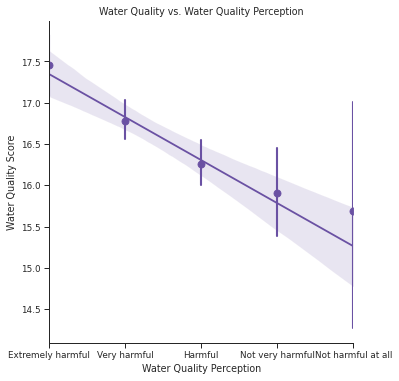

In [229]:
h1_fig1 = sns.lmplot(
    data=cgss_wq_l14d,
    x = 'l14d',
    y = 'score',
    x_estimator=np.mean,
    )
h1_fig1.set(xlabel='Water Quality Perception', ylabel='Water Quality Score', title='Water Quality vs. Water Quality Perception')

h1_fig1.ax.set_xticks([1,2,3,4,5])
h1_fig1.set_xticklabels(l14d_labels)

h1_fig1.savefig('outputs/h1_fig1.png', dpi=600)
h1_fig1.savefig('outputs/h1_fig1.svg')

In [230]:
pi.corr(x=cgss_wq_l14d['score'], y=cgss_wq_l14d['l14d'])

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,3253,-0.1023,"[-0.14, -0.07]",0.010465,0.009856,4.980902e-09,5.811e+05,0.999951


#### Initial findings:
- While the correlation is significant (Low $p$ value == more compelled to reject null hypothesis), there is a poor regression fit (low r²)
- Multivariable analysis required for further investigation

### H2 - An increase knowledge of water quality issues (`l2409`) relates to an increased perception of severity (`l14d`).

Clean data for `l2409` using previously cleaned `l14d` dataframe:
**NOTE**: Only keeping binary responses (dropping *Can't respond* value `8`)

In [231]:
cgss_wq_l14d_l2409 = cgss_wq_l14d[cgss_wq_l14d["l2409"]>0]
cgss_wq_l14d_l2409 = cgss_wq_l14d_l2409[cgss_wq_l14d_l2409["l2409"]<3]

In [232]:
h2 = cgss_wq_l14d_l2409.groupby('l2409').agg('mean')
h2

,score,s41,a2,a3a,a7a,a8a,a91,l1a,l1b,l6a,l6b,l7a,l7b,l8a,l8b,l137,l14d,l15a,l15b,l16c,l20e
l2409,,,,,,,,,,,,,,,,,,,,,
1.0,16.223121,16.046099,1.482270,1964.570922,5.109929,1258061.250,1.576512,6.521277,6.414894,3.833333,2.414894,7.414894,6.581560,2.836879,2.521277,3.567376,2.382979,2.471631,2.297872,2.769504,2.329787
2.0,16.891944,15.031088,1.452504,1965.616580,6.341969,1422613.875,1.704663,5.155440,6.892919,3.827288,2.018998,7.652850,8.120898,3.138169,2.737478,3.854922,2.186528,2.485320,2.412781,2.892919,2.307427


Count the number of responses per `l2409`

In [233]:
cgss_wq_l14d_l2409["l2409"].value_counts()

2.0    579
1.0    282
Name: l2409, dtype: int64

Now, plot: (`l2409==2` is the correct answer)

(note - info on setting legend lables can be found [here](https://stackoverflow.com/questions/45201514/edit-seaborn-legend))

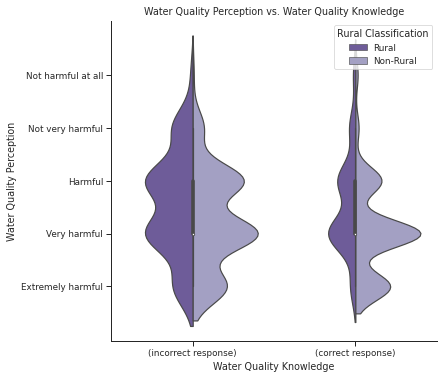

In [234]:
h2_fig1 = sns.catplot(
    data=cgss_wq_l14d_l2409,
    x = 'l2409',
    y = 'l14d',
    hue='a91',
    split=True,
    kind='violin',
    scale='count',
    legend_out=False
    )
h2_fig1.set(xlabel='Water Quality Knowledge', ylabel='Water Quality Perception', title='Water Quality Perception vs. Water Quality Knowledge')
h2_fig1._legend.set_title('Rural Classification')

h2_fig1.set_xticklabels(l2409_labels)
h2_fig1.ax.set_yticks([1,2,3,4,5])
h2_fig1.set_yticklabels(l14d_labels)
for t, l in zip(h2_fig1._legend.texts, a91_labels): t.set_text(l) # see source above
h2_fig1.savefig('outputs/h2_fig1.png', dpi=600)
h2_fig1.savefig('outputs/h2_fig1.svg')

Plot again - note that the line connecting the two isn't relevant or accurate

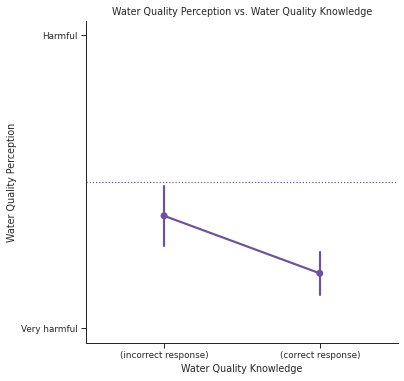

In [235]:
h2_fig2 = sns.catplot(
    data=cgss_wq_l14d_l2409,
    x = 'l2409',
    y = 'l14d',
    kind='point',
    #hue='a91',
    )

h2_fig2.set(xlabel='Water Quality Knowledge', ylabel='Water Quality Perception', title='Water Quality Perception vs. Water Quality Knowledge')

h2_fig2.set_xticklabels(l2409_labels)
h2_fig2.ax.set_yticks([1,2,3,4,5])
h2_fig2.set_yticklabels(l14d_labels)
h2_fig2.ax.set_ylim(1.95,3.05)

plt.axhline(2.5,linestyle=':')
h2_fig2.savefig('outputs/h2_fig2.png', dpi=600)
h2_fig2.savefig('outputs/h2_fig2.svg')

In [236]:
pi.corr(x=cgss_wq_l14d_l2409['l2409'], y=cgss_wq_l14d_l2409['l14d'], method='kendall')

,n,r,CI95%,r2,adj_r2,p-val,power
kendall,861,-0.10499,"[-0.17, -0.04]",0.011023,0.008718,0.000906,0.870417


#### Initial findings:
- Increased water quality knowledge `l2409==2` has an increased perception (decreased `l14d`).
    - Statistically significant ($p<=0.05$) but weakly correlated ($0<r<.19$)
- However, this trend is no longer visible when factoring for rural/urban `a91`, education level `a7a`, etc
- Other large differences between rural/non-rural exist (see `h2` above)
- More analysis is needed

### H3 - Increased education (`a7a`) relates to more knowledge about water quality (`l2409`).


Clean data for `l2409`

Again, **NOTE**: Only keeping binary responses (dropping "*Can't respond*" value `8`)

In [237]:
cgss_wq_l2409 = cgss_wq[cgss_wq["l2409"]>0]
cgss_wq_l2409 = cgss_wq_l2409[cgss_wq_l2409["l2409"]<3]

Now, clean for education `a7a`

In [238]:
cgss_wq_l2409_a7a = cgss_wq_l2409[cgss_wq_l2409["a7a"]>=0]
cgss_wq_l2409_a7a = cgss_wq_l2409_a7a[cgss_wq_l2409_a7a["a7a"]<14]

Now, plot:

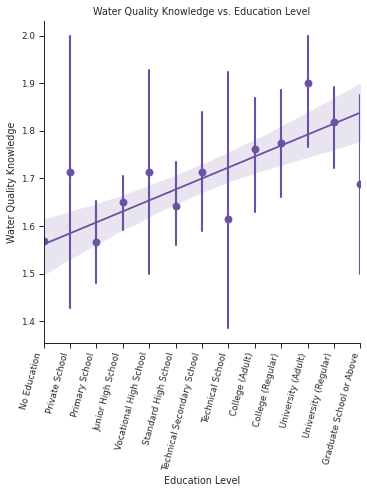

In [239]:
h3_fig1 = sns.lmplot(
    data=cgss_wq_l2409_a7a,
    x = 'a7a',
    y = 'l2409',
    x_estimator=np.mean,
    )
h3_fig1.set(xlabel='Education Level', ylabel='Water Quality Knowledge', title='Water Quality Knowledge vs. Education Level')

h3_fig1.ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,13])
h3_fig1.set_xticklabels(a7a_labels, rotation=75, ha = 'right')

#h3_fig1.ax.set_yticks([1,2])
#h3_fig1.set_yticklabels(l2409_labels)


h3_fig1.savefig('outputs/h3_fig1.png', dpi=600)
h3_fig1.savefig('outputs/h3_fig1.svg')

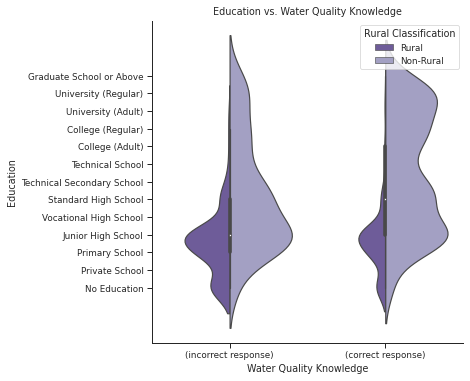

In [240]:
h3_fig2 = sns.catplot(
    data=cgss_wq_l2409_a7a,
    x = 'l2409',
    y = 'a7a',
    hue='a91',
    split=True,
    kind='violin',
    scale='count',
    legend_out=False
    )
h3_fig2.set(xlabel='Water Quality Knowledge', ylabel='Education', title='Education vs. Water Quality Knowledge')

h3_fig2.ax.set_yticks([1,2,3,4,5,6,7,8,9,10,11,12,13])
h3_fig2.set_yticklabels(a7a_labels)

#h3_fig2.ax.set_xticks([0,1])
h3_fig2.set_xticklabels(l2409_labels)

h3_fig2.legend.set_title('Rural Classification')
for t, l in zip(h3_fig2._legend.texts, a91_labels): t.set_text(l) # see source in Hypothesis 2 section

h3_fig2.savefig('outputs/h3_fig2.png', dpi=600)
h3_fig2.savefig('outputs/h3_fig2.svg')

In [241]:
pi.corr(x=cgss_wq_l2409_a7a['l2409'], y=cgss_wq_l2409_a7a['a7a'], method='spearman')

,n,r,CI95%,r2,adj_r2,p-val,power
spearman,881,0.163802,"[0.1, 0.23]",0.026831,0.024614,0.000001,0.998361


#### Initial findings
- There seems to be a slight trend (education increase relates to knowledge increase)
- The violin plots show differences in rural vs non-rural responses
- More analysis is needed

## H4 - Increased education `a7a` relates to an increased perception of severity `l14d`

First, see the distribution of education:

array([[<AxesSubplot:title={'center':'a7a'}>,
        <AxesSubplot:title={'center':'l14d'}>]], dtype=object)

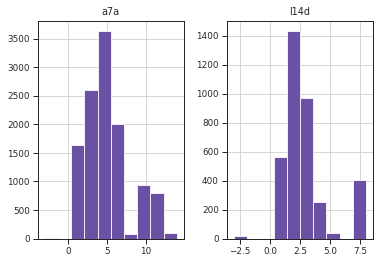

In [242]:
cgss_wq[["a7a","l14d"]].hist()

Make new cleaned dataset with cleaned `a7a` values from the previously cleaned `l14d` values

In [243]:
cgss_wq_l14d_a7a = cgss_wq_l14d[cgss_wq_l14d['a7a']>=0]

Group by each education level (year) and aggregate the mean

In [244]:
h4 = cgss_wq_l14d_a7a.groupby('a7a').agg('mean')

Plot result (perception vs. education level). 

**Note**: Since `a7a` is the index of h4, it needs to be reset before being plotted in regplot (info [here](https://www.reddit.com/r/learnpython/comments/3cjnpg/seaborn_xaxis_as_index/))

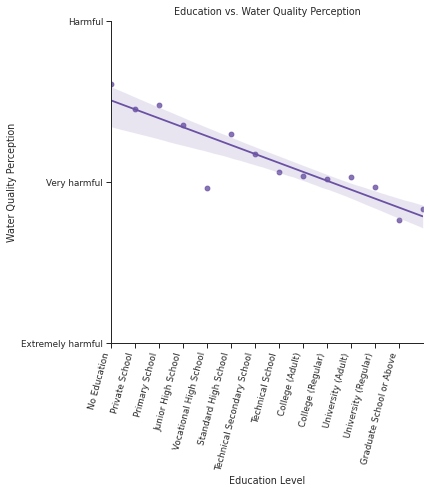

In [245]:
h4_fig1 = sns.lmplot(
    data=h4.reset_index(),
    x = 'a7a',
    y = 'l14d'
    )
h4_fig1.set(xlabel='Education Level', ylabel='Water Quality Perception', title='Education vs. Water Quality Perception')

h4_fig1.ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,13])
h4_fig1.set_xticklabels(a7a_labels, rotation=75, ha = 'right')

h4_fig1.ax.set_yticks([1,2,3,4,5])
h4_fig1.set_yticklabels(l14d_labels)
h4_fig1.ax.set_ylim(1,3)

h4_fig1.savefig('outputs/h4_fig1.png', dpi=600)
h4_fig1.savefig('outputs/h4_fig1.svg', dpi=600)

It's better (?) to use an lmplot (similar to regplot) and calculate the mean per x bin, from [here](https://seaborn.pydata.org/tutorial/regression.html).
> A second option is to collapse over the observations in each discrete bin to plot an estimate of central tendency along with a confidence interval:

Additionally, the lmplot allows for multiple regressions to be plotted on the same plot.

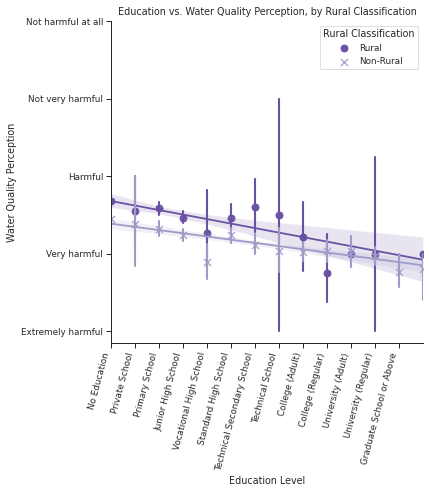

In [246]:
h4_fig2 = sns.lmplot(
    data=cgss_wq_l14d_a7a,
    x = 'a7a',
    y = 'l14d',
    x_estimator=np.mean,
    hue='a91',
    markers=(["o", "x"]),
    legend_out=False
    )
h4_fig2.set(xlabel='Education Level', ylabel='Water Quality Perception', title='Education vs. Water Quality Perception, by Rural Classification')

h4_fig2.ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,13])
h4_fig2.set_xticklabels(a7a_labels, rotation=75, ha = 'right')

h4_fig2.ax.set_yticks([1,2,3,4,5])
h4_fig2.set_yticklabels(l14d_labels)

h4_fig2.legend.set_title('Rural Classification')
for t, l in zip(h4_fig2._legend.texts, a91_labels): t.set_text(l) # see source in Hypothesis 2 section
  
h4_fig2.savefig('outputs/h4_fig2.png', dpi=600)
h4_fig2.savefig('outputs/h4_fig2.svg')

In [247]:
pi.corr(x=cgss_wq_l14d_a7a['a7a'], y=cgss_wq_l14d_a7a['l14d'])

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,3252,-0.210865,"[-0.24, -0.18]",0.044464,0.043876,5.256292e-34,2.634e+30,1.0


### Initial findings:
- There is a clear trend between education and perception
- Rural households have a higher `l14d` than non-rural at each education level
    - This difference decreases as education increases

### H5 - There is a significant difference in perception of severity of water quality issues (`l14d`) between urban and rural households (`a91`).

Reuse the cleaned data from `H1` for question `l14d`, see number of responses by type by grouping by `a91`, where a91==1 is rural

In [248]:
cgss_wq_l14d[['a91','l14d']].groupby('a91').agg('count')

,l14d
a91,
1.0,1257
2.0,1995


Calculate the mean `l14d` grouped by rural / urban

In [249]:
h5_l14d = cgss_wq_l14d.groupby('a91').agg('mean')
h5_l14d

,score,s41,a2,a3a,a7a,a8a,l1a,l1b,l6a,l6b,l7a,l7b,l8a,l8b,l137,l14d,l15a,l15b,l16c,l20e,l2409
a91,,,,,,,,,,,,,,,,,,,,,
1.0,16.028347,16.902147,1.508353,1963.584726,3.479714,1051191.500,9.197295,10.362768,3.617343,2.715990,12.665871,12.211615,2.710422,2.401750,3.642005,2.536197,3.121718,3.120127,3.466985,2.669053,6.357995
2.0,17.060171,14.374436,1.524311,1962.532331,6.238596,1622341.125,7.379449,8.115288,3.815038,2.151378,9.243108,9.663659,3.027068,2.653133,3.842105,2.172431,2.950376,2.893734,3.099248,2.309774,6.121805


In [250]:
h5_l2409 = cgss_wq_l2409.groupby('a91').agg('mean')
h5_l2409

,score,s41,a2,a3a,a7a,a8a,l1a,l1b,l6a,l6b,l7a,l7b,l8a,l8b,l137,l14d,l15a,l15b,l16c,l20e,l2409
a91,,,,,,,,,,,,,,,,,,,,,
1.0,15.791478,18.277592,1.491639,1965.163880,3.628763,9.452673e+05,5.695652,7.133779,3.632107,2.515050,7.882943,8.461538,2.702341,2.327759,3.468227,2.678930,2.321070,2.167224,2.862876,2.581940,1.598662
2.0,17.062132,13.874785,1.445969,1965.123499,7.060034,1.588319e+06,5.797599,6.706690,3.924528,1.972556,7.922813,7.530017,3.193825,2.819897,3.910806,2.229846,2.557461,2.475129,2.852487,2.183533,1.715266


In [251]:
pi.corr(x=cgss_wq_l14d['a91'], y=cgss_wq_l14d['l14d'], method='spearman')

,n,r,CI95%,r2,adj_r2,p-val,power
spearman,3252,-0.201821,"[-0.23, -0.17]",0.040732,0.040141,3.094507e-31,1.0


In [252]:
pi.corr(x=cgss_wq_l2409['a91'], y=cgss_wq_l2409['l2409'], method='kendall')

,n,r,CI95%,r2,adj_r2,p-val,power
kendall,882,0.117917,"[0.05, 0.18]",0.013904,0.011661,0.000465,0.939931


#### Initial findings: 
- There is a difference between rural and urban households (rural have less severe perception of water quality)
- Education level (`a7a`) is significantly different between urban and rural households

### H6 - There is a relation between water quality `score` and water quality knowledge `l2409`.

Drop negative values, keep `l2409` == 8 this time ("*Can't answer*")

In [253]:
cgss_wq_score_l2409_8 = cgss_wq[cgss_wq['l2409'].isin([1,2,8])]

In [254]:
cgss_wq_score_l2409_8.groupby('l2409').agg('mean')

,score,s41,a2,a3a,a7a,a8a,a91,l1a,l1b,l6a,l6b,l7a,l7b,l8a,l8b,l137,l14d,l15a,l15b,l16c,l20e
l2409,,,,,,,,,,,,,,,,,,,,,
1.0,16.197448,16.101046,1.484321,1964.585366,5.083624,1271105.5,1.580420,6.787456,6.672474,3.825784,2.404181,7.668990,6.554007,2.815331,2.491289,3.547038,2.442509,2.459930,2.296167,2.766551,2.324042
2.0,16.846471,15.040269,1.451342,1965.412752,6.298658,1415841.5,1.699664,5.261745,6.939597,3.825503,2.036913,8.015101,8.468121,3.132550,2.729866,3.860738,2.352349,2.484899,2.406040,2.901007,2.315436
8.0,16.560695,15.326776,1.546448,1961.880146,4.699454,1446802.5,1.574135,10.890710,12.264117,3.697268,2.723133,16.091803,15.110747,2.887796,2.560656,3.877960,3.103825,3.472495,3.459381,3.671767,2.550091


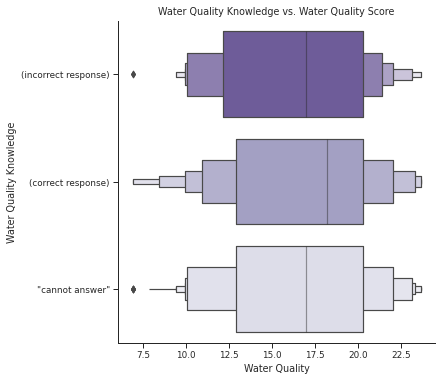

In [255]:
h6_fig1 = sns.catplot(
    data=cgss_wq[~cgss_wq['l2409'].isin([-3,-2])],
    y = 'l2409',
    x = 'score',
    # hue='a91',
    #split=True,
    kind='boxen',
    # scale='mean',
    orient='h',
    )
h6_fig1.set(xlabel='Water Quality', ylabel='Water Quality Knowledge', title='Water Quality Knowledge vs. Water Quality Score')

#h6_fig1.ax.set_yticks([1,2,3])
h6_fig1.set_yticklabels(['(incorrect response)','(correct response)', '"cannot answer"'])

h6_fig1.savefig('outputs/h6_fig1.png', dpi=600)
h6_fig1.savefig('outputs/h6_fig1.svg')

In [256]:
pi.corr(x=cgss_wq_score_l2409_8['score'], y=cgss_wq_score_l2409_8['l14d'], method='kendall')

,n,r,CI95%,r2,adj_r2,p-val,power
kendall,3628,-0.095982,"[-0.13, -0.06]",0.009213,0.008666,2.450049e-14,0.999938


---

## Additional descriptive analysis

### `l6`
Start with `l6`, where:
- `l6a` asks "Generally speaking, how much do you care about environmental issues?
- `l6b` asks "Based on your own judgment, on the whole, do you think the environmental problems facing China are serious?"

First, clean data: (**Note**: When I tried this in one step (two columns), I was having graph issues later, so I did each step individually)

In [257]:
cgss_wq_l6 = cgss_wq[cgss_wq['l6a']>0]
cgss_wq_l6 = cgss_wq_l6[cgss_wq_l6['l6a']<6]
cgss_wq_l6 = cgss_wq_l6[cgss_wq_l6['l6b']>0]
cgss_wq_l6 = cgss_wq_l6[cgss_wq_l6['l6b']<6]
l6ab = cgss_wq_l6[['l6a','l6b']]

Plot

<Figure size 792x792 with 0 Axes>

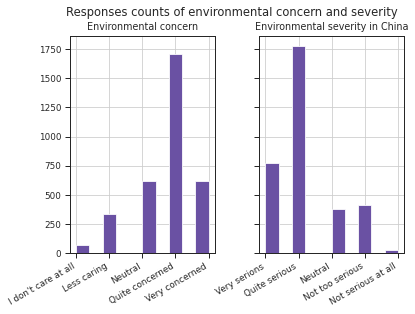

In [258]:
fig = plt.figure(figsize=(11, 11))
fig, ax = plt.subplots(1,2, sharex=False, sharey=True)

fig.suptitle('Responses counts of environmental concern and severity')

cgss_wq_l6.hist(['l6a','l6b'], ax=ax)

ax[0].set_title('Environmental concern')
ax[0].set_xticks([1,2,3,4,5])
ax[0].set_xticklabels(l6a_labels, rotation=30, ha = 'right')

ax[1].set_title('Environmental severity in China')
ax[1].set_xticks([1,2,3,4,5])
ax[1].set_xticklabels(l6b_labels, rotation=30, ha = 'right')

fig.savefig('outputs/l6_fig1.png', dpi=600, bbox_inches = 'tight')
fig.savefig('outputs/l6_fig1.svg', bbox_inches = 'tight')

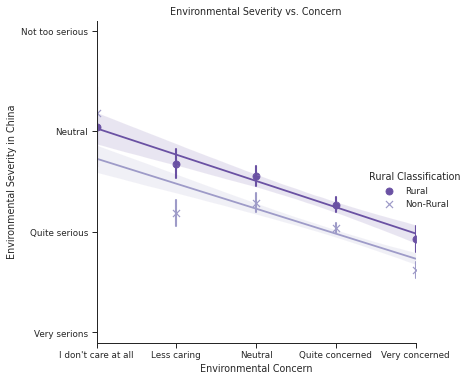

In [259]:
l6_fig2 = sns.lmplot(
    data=cgss_wq_l6,
    x = 'l6a',
    y = 'l6b',
    x_estimator=np.mean,
    hue='a91',
    markers=(["o", "x"])
    )
l6_fig2.set(xlabel='Environmental Concern', ylabel='Environmental Severity in China', title='Environmental Severity vs. Concern')

l6_fig2.ax.set_xticks([1,2,3,4,5])
l6_fig2.set_xticklabels(l6a_labels)

l6_fig2.ax.set_yticks([1,2,3,4,5])
l6_fig2.set_yticklabels(l6b_labels)
l6_fig2.ax.set_ylim(0.9,4.1)

l6_fig2.legend.set_title('Rural Classification')
for t, l in zip(l6_fig2._legend.texts, a91_labels): t.set_text(l) # see source in Hypothesis 2 section

l6_fig2.savefig('outputs/l6_fig2.png', dpi=600)
l6_fig2.savefig('outputs/l6_fig2.svg')

In [260]:
pi.corr(x=cgss_wq_l6['l6a'], y=cgss_wq_l6['l6b'])

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,3362,-0.272594,"[-0.3, -0.24]",0.074307,0.073756,2.322155e-58,4.335e+54,1.0


### `l7`

Compare with `l7` ("Which issue do you think is the most important environmental issue in China?")
- `l7a`: most important to China
- `l7b`: most impactful to family

Values:
- Air Pollution - 1
- Fertilizer and pesticide pollution - 2
- Water scarcity - 3
- Water pollution - 4
- Nuclear waste - 5
- Disposal of domestic waste - 6
- Climate Change - 7
- Genetically modified food - 8
- Depletion of natural resources - 9
- None of the above - 10
- Cannot select - 98

Convert to dataframe

In [261]:
l7_df = pd.DataFrame.from_dict(l7_labels, orient='index', columns=['l7a'])

**Attempting to put labels on histogram below, but can't**

Clean data, drop 10 & 98 (use the '~' to negate the .isin() function)
Cleaning both at the same time results in the same as doing it individually

In [262]:
cgss_wq_l7=cgss_wq[~cgss_wq[['l7a','l7b']].isin([-3,-1,98])]

In [263]:
cgss_wq_l7[['l7a','l7b']].describe()

,l7a,l7b
count,3253.000000,3298.000000
mean,3.554565,3.990297
std,2.478664,2.725078
min,1.000000,1.000000
25%,1.000000,1.000000
50%,4.000000,4.000000
75%,6.000000,6.000000
max,10.000000,10.000000


<ipython-input-264-b89f1981b423>:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  cgss_wq_l7.hist(['l7a','l7b'], ax=ax)


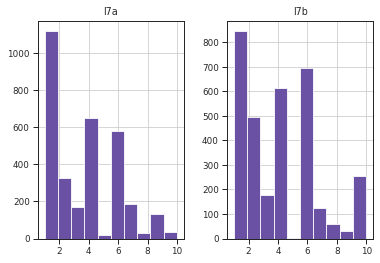

In [264]:
fig, ax = plt.subplots()
cgss_wq_l7.hist(['l7a','l7b'], ax=ax)
fig.savefig('outputs/l7_fig1.png', dpi=600)
fig.savefig('outputs/l7_fig1.svg')

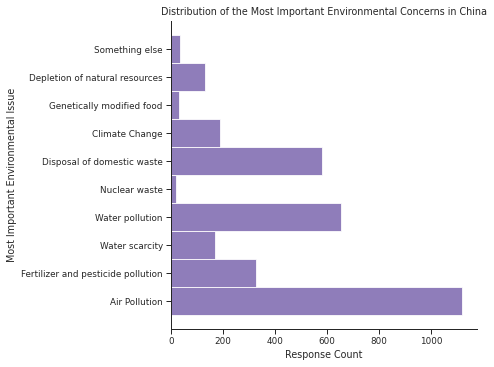

In [265]:
l7_fig2 = sns.displot(
    data=cgss_wq_l7, 
    y='l7a', 
    # hue='l7b', 
    discrete = True,
    bins=11,
    # multiple='stack',
    kind = 'hist'
    )
l7_fig2.set(ylabel='Most Important Environmental Issue', xlabel='Response Count', title='Distribution of the Most Important Environmental Concerns in China')
l7_fig2.ax.set_yticks([1,2,3,4,5,6,7,8,9,10])
l7_fig2.set_yticklabels(l7_labels)
l7_fig2.savefig('outputs/l7_fig2.png', dpi=600)
l7_fig2.savefig('outputs/l7_fig2.svg')

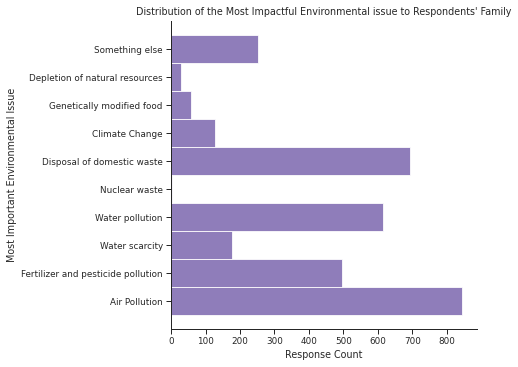

In [266]:
l7_fig3 = sns.displot(
    data=cgss_wq_l7, 
    y='l7b',
    discrete = True, 
    bins = 11,
    kind = 'hist'
    )
l7_fig3.set(ylabel='Most Important Environmental Issue', xlabel='Response Count', title="Distribution of the Most Impactful Environmental issue to Respondents' Family")
l7_fig3.ax.set_yticks([1,2,3,4,5,6,7,8,9,10])
l7_fig3.set_yticklabels(l7_labels)
l7_fig3.savefig('outputs/l7_fig3.png', dpi=600)
l7_fig3.savefig('outputs/l7_fig3.svg')

<div class="alert alert-block alert-info">
<b>Note:</b> Sections below are not final. Work in progress (March 31st, 2021).</div>

### Water Quality in Rivers by proportion (from World Bank document)

Inspired by [this post](https://www.pythoncharts.com/python/stacked-bar-charts/#plotnine-stacked-bar-charts)

In [267]:
river_wq = pd.read_csv('river_wq.csv')

#turn decimals into percent (/100)
river_wq.percentage = river_wq.percentage.mul(100).round(3) #.astype(str).add('%')
river_wq

,year,percentage,class
0,2002,46.3,I-III
1,2002,26.1,IV-V
2,2002,27.6,V+
3,2007,49.9,I-III
4,2007,26.5,IV-V
5,2007,23.6,V+
6,2012,68.9,I-III
7,2012,20.9,IV-V
8,2012,10.2,V+
9,2017,71.8,I-III


In [268]:
agg_river_wq = river_wq.groupby(['year', 'class'])['percentage'].sum().unstack().fillna(0)
agg_river_wq

class,I-III,IV-V,V+
year,,,
2002,46.3,26.1,27.6
2007,49.9,26.5,23.6
2012,68.9,20.9,10.2
2017,71.8,19.8,8.4


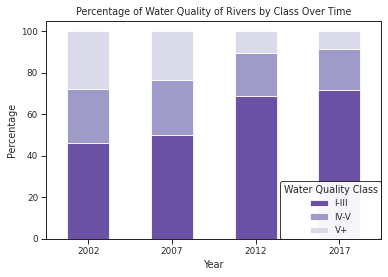

In [269]:
agg_river_wq.plot(kind='bar', stacked=True)

# Just add a title and rotate the x-axis labels to be horizontal.
plt.title('Percentage of Water Quality of Rivers by Class Over Time')
plt.xticks(rotation=0, ha='center')
plt.xlabel('Year')
plt.yticks()
plt.ylabel('Percentage')
plt.legend(
    loc='lower right', 
    bbox_to_anchor=(1, 0),
    borderaxespad=0,
    edgecolor='black',
    title='Water Quality Class',
    framealpha=.95
    )
plt.savefig('outputs/river_wq.png', dpi=600)
plt.savefig('outputs/river_wq.svg')

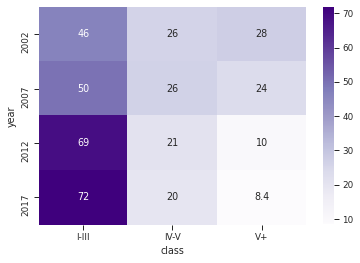

In [156]:
ax = sns.heatmap(agg_river_wq, annot=True, cmap = 'Purples')

## Multivariable statistical analysis

In [63]:
ols_perception = smf.ols('l14d ~ score + C(a2) + a3a + a7a + C(a91)', data = cgss_wq).fit()
ols_perception.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   l14d   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     51.50
Date:                Wed, 31 Mar 2021   Prob (F-statistic):           9.21e-52
Time:                        21:38:49   Log-Likelihood:                -7618.3
No. Observations:                3671   AIC:                         1.525e+04
Df Residuals:                    3665   BIC:                         1.529e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         4.4156      1.174      3.761      0.000       2.114       6.717
C(a2)[T.2]        0.0559      0.065      0.865      0.387      -0.071       0.183
C(a91)[T.1.0]     2.3748      0.591      4.018      0.000       1.216       3.533
C(a91)[T.2.0]     2.0408      0.585      3.487      0.000       0.893       3.188
score            -0.0248      0.007     -3.446      0.001      -0.039      -0.011
a3a              -0.0014      0.001     -1.518      0.129      -0.003       0.000
a7a              -0.1223      0.012    -10.140      0.000      -0.146      -0.099
==============================================================================
Omnibus:                      912.726   Durbin-Watson:                   1.849
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1900.260
Skew:                           1.460   Prob(JB):                         0.00
Kurtosis:                       4.974   Cond. No.                     2.36e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.55e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [64]:
ols_knowledge = smf.ols('l2409 ~ score + C(a2) + C(a91)', data = cgss_wq).fit()
ols_knowledge.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  l2409   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     10.30
Date:                Wed, 31 Mar 2021   Prob (F-statistic):           9.48e-07
Time:                        21:38:49   Log-Likelihood:                -9076.6
No. Observations:                3671   AIC:                         1.816e+04
Df Residuals:                    3667   BIC:                         1.819e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.9345      0.124     31.740      0.000       3.691       4.178
C(a2)[T.2]        0.3458      0.095      3.643      0.000       0.160       0.532
C(a91)[T.1.0]     2.1612      0.076     28.491      0.000       2.013       2.310
C(a91)[T.2.0]     1.7733      0.082     21.725      0.000       1.613       1.933
score             0.0185      0.011      1.747      0.081      -0.002       0.039
==============================================================================
Omnibus:                      617.759   Durbin-Watson:                   1.683
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              991.087
Skew:                          -1.273   Prob(JB):                    6.14e-216
Kurtosis:                       3.017   Cond. No.                     2.06e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.56e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## NOTES
- Normalize variables (variance is different)
- Cannot use OLS, use LOGIT (logistic regression)

Things to change in the code
1. not use OLS for categorical output but use LOGIT (logitstic regression) to model categorical output
2. normalise continous variables as in the example notebook
3. Use the C(...) for categoricals 
4. To use to logit, you need a binary output:
4.a remove '8' answers to construct a first model and validate it
4.b. since most answers are '8' and you don't want to discard them, create a new logistic regression model with ternary output (this is possible)

R² shows model explains variation in dependent variable, while R is correlation between one variable and another
- With my correlation analysis, use R
- If I use OLS, use R²

## Data overview

### Responses per province by type

In [66]:
dem_dist = cgss_wq[demographic].dropna().groupby('s41').agg('count')

In [67]:
env_dist = cgss_wq[environmental].dropna().groupby('s41').agg('count')
env_dist

,province,province_en,score,l1a,l1b,l6a,l6b,l7a,l7b,l8a,l8b,l14d,l2409
s41,,,,,,,,,,,,,
1.0,183,183,183,183,183,183,183,183,183,183,183,183,183
2.0,103,103,103,103,103,103,103,103,103,103,103,103,103
3.0,28,28,28,28,28,28,28,28,28,28,28,28,28
4.0,173,173,173,173,173,173,173,173,173,173,173,173,173
5.0,164,164,164,164,164,164,164,164,164,164,164,164,164
6.0,179,179,179,179,179,179,179,179,179,179,179,179,179
7.0,120,120,120,120,120,120,120,120,120,120,120,120,120
8.0,27,27,27,27,27,27,27,27,27,27,27,27,27
9.0,126,126,126,126,126,126,126,126,126,126,126,126,126


---
### Education and Score

In [68]:
cgss_wq_a7a = cgss_wq[~cgss_wq['a7a'].isin([-3,14])].dropna()
cgss_wq_a7a

,score,s41,a2,a3a,a7a,a8a,a91,l1a,l1b,l6a,l6b,l7a,l7b,l8a,l8b,l137,l14d,l15a,l15b,l16c,l20e,l2409,province,province_en
3,13.84,28.0,2,1948,1,0.0,2.0,8.0,2.0,4.0,8.0,98.0,98.0,8.0,8.0,2.0,8.0,8.0,8.0,8.0,4.0,8.0,重庆,Chongqing
5,13.84,28.0,1,1963,4,20000.0,2.0,2.0,6.0,4.0,2.0,3.0,6.0,4.0,4.0,4.0,2.0,8.0,2.0,2.0,2.0,8.0,重庆,Chongqing
6,13.84,28.0,1,1952,3,9999998.0,1.0,1.0,2.0,4.0,4.0,3.0,3.0,3.0,4.0,4.0,3.0,8.0,8.0,2.0,4.0,8.0,重庆,Chongqing
8,13.84,28.0,2,1973,3,4200.0,2.0,98.0,98.0,4.0,2.0,1.0,4.0,3.0,2.0,4.0,1.0,1.0,1.0,4.0,4.0,8.0,重庆,Chongqing
11,13.84,28.0,1,1964,4,5000.0,2.0,3.0,6.0,4.0,2.0,7.0,98.0,8.0,8.0,4.0,4.0,8.0,8.0,4.0,1.0,8.0,重庆,Chongqing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11770,17.93,8.0,2,1961,1,7500.0,1.0,8.0,6.0,5.0,1.0,4.0,4.0,2.0,2.0,5.0,1.0,1.0,2.0,2.0,2.0,8.0,宁夏,Ningxia
11773,17.93,8.0,2,1963,3,2600.0,1.0,2.0,6.0,5.0,4.0,6.0,6.0,2.0,2.0,2.0,3.0,1.0,2.0,4.0,2.0,8.0,宁夏,Ningxia
11774,17.93,8.0,1,1956,1,4500.0,1.0,1.0,2.0,5.0,4.0,6.0,6.0,1.0,2.0,2.0,4.0,2.0,2.0,5.0,4.0,1.0,宁夏,Ningxia
11775,17.93,8.0,2,1982,3,5000.0,2.0,8.0,2.0,2.0,2.0,8.0,3.0,1.0,1.0,1.0,3.0,2.0,2.0,1.0,4.0,1.0,宁夏,Ningxia


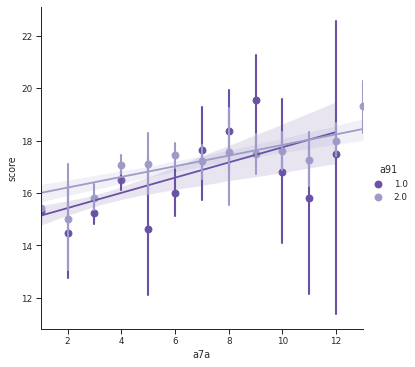

In [69]:
sns.lmplot(
    data=cgss_wq_a7a,
    x = 'a7a',
    y = 'score',
    x_estimator=np.mean,
    hue='a91'
    )